This notebook tests various machine learning models based on previously pre-processed wine dataset and compare metrics to identify which classify wine quality most accurately.

## 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, cohen_kappa_score
from imblearn.metrics import geometric_mean_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from plotly import graph_objects as go
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbpipeline

## 2. Reading data

### 2.1 Function:

In [2]:
def read_data(path):                
    directory = path + 'cleaned_wine_data.csv'
    dataset = pd.read_csv(directory, index_col=[0])
    return dataset

### 2.2 Application:

In [3]:
wine_data = read_data('/Users/aleksandra/Desktop/Data-Science-Project-main/')
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,1,-0.695163,-0.261684,0.144245,-0.766859,-0.208407,-0.900220,0.314921,-0.180598,0.472180,-0.288309,-0.885144,1
2,1,0.667890,-0.380575,0.552136,0.410863,-0.181305,-0.002628,-0.301474,0.189947,0.222398,-0.622007,-0.379421,1
3,1,-0.013636,-0.677803,0.008281,0.766401,0.035512,0.951064,1.265929,0.358377,-0.214721,-0.888964,-0.547996,1
6,1,-0.770888,-0.142793,-1.079428,0.433084,-0.316815,-0.002628,0.385366,0.122576,-0.277166,-0.421788,-0.800857,1
9,1,0.667890,-0.737249,0.756081,-0.789080,-0.343917,-0.114827,0.262087,-0.247970,-0.027384,-0.555267,0.379162,1


## 3. Data preparation

**Data split**

In [4]:
X = wine_data.drop(['quality'], axis=1)
y = wine_data['quality']

**Train-test split**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 4. Features selection

We will check whether all our features are useful for training our model. We will use forests of trees to evaluate the importance of features. 

Feature ranking:
1. feature 2 (0.104943)
2. feature 6 (0.102563)
3. feature 11 (0.091795)
4. feature 10 (0.090428)
5. feature 4 (0.088189)
6. feature 3 (0.086759)
7. feature 7 (0.086474)
8. feature 9 (0.086010)
9. feature 8 (0.085548)
10. feature 1 (0.084852)
11. feature 5 (0.083175)
12. feature 0 (0.009263)


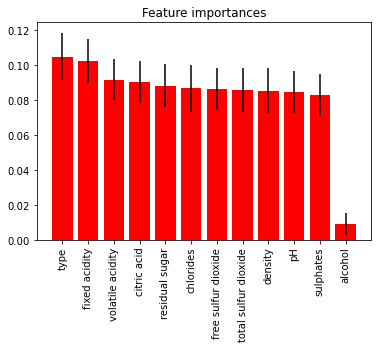

In [6]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
    color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
feature_names = X_train.columns
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.show()

We will use first 6 features with the highest importance.

In [7]:
model = SelectFromModel(forest, prefit=True, max_features=6)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(4106, 6)
(1027, 6)


## 5. Cross-validation and metrics preparation

We will be checking our models for the dataset that is imbalanced (X_train, y_train) as well as balanced dataset (X_balanced, y_balanced).

The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset.

In [8]:
kfold = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

We will also create dictionaries for adding all the metrics for each model. We will use 5 metrics for our dataset:

- **f1 score** - is the harmonic mean between precision and recall, it tells how precise the classifier is and how robust it is 

- **acuracy score** - it is the ratio of number of correct predictions to the total number of input samples

- **balanced accuracy score** - it is calculated as the average of the proportion corrects of each class individually

- **cohen kappa score** - measures inter-rater agreement for qualitative (categorical) items.
More: https://medium.com/x8-the-ai-community/kappa-coefficient-for-dummies-84d98b6f13ee

- **geometric mean score** - measures the balance between classification performances on both the majority and minority classes.

In [9]:
models = {}
f1_scores = {}
accuracy_scores = {}
balanced_accuracy_scores = {}
cohen_kappa_scores = {}
geometric_mean_scores = {}

In this step, we will also define a function for calculating metrics and adding them to our dictionaries. This function takes classificator name and grid best estimator as arguments.

In [10]:
def show_metrics(name, best_params):
    print(name)

    accuracy_scores[name] = accuracy_score(y_test, best_params.predict(X_test))
    print("accuracy_score: {}".format(accuracy_scores[name]))
    
    balanced_accuracy_scores[name] = balanced_accuracy_score(y_test, best_params.predict(X_test))
    print("balanced_accuracy_score: {}".format(balanced_accuracy_scores[name])) 
    
    cohen_kappa_scores[name] = cohen_kappa_score(y_test, best_params.predict(X_test))
    print("cohen_kappa_score: {}".format(cohen_kappa_scores[name]))
    
    geometric_mean_scores[name] = geometric_mean_score(y_test, best_params.predict(X_test))
    print("geometric_mean_score: {}".format(geometric_mean_scores[name]))     

## 5. KNN classification

We will start with K-Nearest Neighbor Classification model.

### 5.1 Balanced dataset:

In [11]:
pipeline_1 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['knn', KNeighborsClassifier()]])

grid_params_1 = {
            'knn__n_neighbors': [3,5,9,11],
            'knn__weights' : ['uniform', 'distance'],
                }

grid_1 = GridSearchCV(
                estimator=pipeline_1,
                param_grid=grid_params_1,
                cv=kfold
                )

grid_1.fit(X_train, y_train)
print(grid_1.best_params_)

{'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [12]:
show_metrics('KNN_balanced', grid_1.best_estimator_)

KNN_balanced
accuracy_score: 0.7409931840311588
balanced_accuracy_score: 0.5459452682856938
cohen_kappa_score: 0.1427271357919313
geometric_mean_score: 0.5253886346735004


### 5.2 Imbalanced dataset:

In [13]:
grid_params_1_imbalanced = {
            'n_neighbors': [3,5,9,11],
            'weights' : ['uniform', 'distance'],
                }

grid_1_imbalanced = GridSearchCV(
                estimator=KNeighborsClassifier(),
                param_grid=grid_params_1_imbalanced,
                cv=kfold
                )

grid_1_imbalanced.fit(X_train, y_train)
print(grid_1_imbalanced.best_params_)

{'n_neighbors': 11, 'weights': 'distance'}


In [14]:
show_metrics('KNN_imbalanced', grid_1_imbalanced.best_estimator_)

KNN_imbalanced
accuracy_score: 0.9152872444011685
balanced_accuracy_score: 0.3333333333333333
cohen_kappa_score: 0.0
geometric_mean_score: 0.0


As we see from the above results we either get higher accuracy for imbalanced dataset and very low class balance or lower accuracy but better class balance for balanced dataset. Let's check other classificators.

## 6. Decision Tree

### 6.1 Balanced dataset:

In [15]:
pipeline_2 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['dtc', DecisionTreeClassifier()]])

grid_params_2 = {
            'dtc__max_depth': [5,9,10,11,20,30],
            'dtc__min_samples_split': [2,3,5,10,20,30,40],
            'dtc__max_leaf_nodes': [3,4,10,14,15,16,20,30,40]
                }

grid_2 = GridSearchCV(
                estimator=pipeline_2,
                param_grid=grid_params_2,
                cv=kfold
                )

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'dtc__max_depth': 9, 'dtc__max_leaf_nodes': 30, 'dtc__min_samples_split': 2}

In [16]:
show_metrics('Decision_Tree_balanced', grid_2.best_estimator_)

Decision_Tree_balanced
accuracy_score: 0.5326192794547225
balanced_accuracy_score: 0.5752310337416721
cohen_kappa_score: 0.07702158971123219
geometric_mean_score: 0.5690330331732459


### 6.2 Imbalanced dataset:

In [17]:
grid_params_2_imbalanced = {
            'max_depth': [5,9,10,11,20,30],
            'min_samples_split': [2,3,5,10,20,30,40],
            'max_leaf_nodes': [3,4,10,14,15,16,20,30,40]
                }

grid_2_imbalanced = GridSearchCV(
                estimator=DecisionTreeClassifier(),
                param_grid=grid_params_2_imbalanced,
                cv=kfold
                )

grid_2_imbalanced.fit(X_train, y_train)

print(grid_2_imbalanced.best_params_)
show_metrics('Decision_Tree_imbalanced', grid_2_imbalanced.best_estimator_)

{'max_depth': 5, 'max_leaf_nodes': 3, 'min_samples_split': 2}
Decision_Tree_imbalanced
accuracy_score: 0.9152872444011685
balanced_accuracy_score: 0.3333333333333333
cohen_kappa_score: 0.0
geometric_mean_score: 0.0


## 7. Random Forest 

### 7.1 Balanced dataset:

In [18]:
pipeline_3 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['rfc', RandomForestClassifier()]])

grid_params_3 = {
            'rfc__max_features': ['auto', 'sqrt'],
            'rfc__min_samples_split': [2, 5, 10],
            'rfc__min_samples_leaf': [1, 2, 4],
            'rfc__bootstrap': [True, False],
            'rfc__max_depth':[30,50]
                }

grid_3 = GridSearchCV(
                    estimator=pipeline_3, 
                    param_grid=grid_params_3,
                    cv=kfold
                     )

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'rfc__bootstrap': False,
 'rfc__max_depth': 50,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 5}

In [19]:
show_metrics('Random_Forest_balanced', grid_3.best_estimator_)

Random_Forest_balanced
accuracy_score: 0.8880233690360273
balanced_accuracy_score: 0.4848687823865128
cohen_kappa_score: 0.22331022872249473
geometric_mean_score: 0.38822033376400605


### 7.2 Imbalanced dataset:

In [20]:
grid_params_3_imbalanced = {
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'max_depth':[30,50]
                }

grid_3_imbalanced = GridSearchCV(
                    estimator=RandomForestClassifier(), 
                    param_grid=grid_params_3_imbalanced,
                    cv=kfold
                     )

grid_3_imbalanced.fit(X_train, y_train)

print(grid_3_imbalanced.best_params_)

{'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [21]:
show_metrics('Random_Forest_imbalanced', grid_3_imbalanced.best_estimator_)

Random_Forest_imbalanced
accuracy_score: 0.9152872444011685
balanced_accuracy_score: 0.3507880220646178
cohen_kappa_score: 0.056365249350484814
geometric_mean_score: 0.0


## 8. Naive Bayes

### 8.1 Balanced dataset:

In [22]:
sm = BorderlineSMOTE(sampling_strategy={0: 1000, 2: 1000},random_state=0)
X_nb, y_nb = sm.fit_resample(X_train, y_train )

In [23]:
nb = GaussianNB()
nb.fit(X_nb, y_nb)

GaussianNB()

In [24]:
show_metrics('Naive_Bayes_balanced', nb)

Naive_Bayes_balanced
accuracy_score: 0.7030185004868549
balanced_accuracy_score: 0.5769193113164744
cohen_kappa_score: 0.13719824594264052
geometric_mean_score: 0.5671295086658846


### 8.2 Imbalanced dataset:

In [25]:
nb.fit(X_train, y_train)

GaussianNB()

In [26]:
show_metrics('Naive_Bayes_imbalanced', nb)

Naive_Bayes_imbalanced
accuracy_score: 0.8977604673807206
balanced_accuracy_score: 0.40840556868925665
cohen_kappa_score: 0.17143691364380276
geometric_mean_score: 0.0


## 9. SVM 

### 9.1 Balanced dataset:

In [27]:
pipeline_4 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['svc', SVC(kernel='rbf')]])

Cs = [0.01, 0.1 , 1]
gammas = [0.01, 0.1, 1]

grid_params_4 = {
            'svc__C': Cs, 
            'svc__gamma' : gammas
                }

grid_4 = GridSearchCV(
                estimator=pipeline_4,
                param_grid=grid_params_4,
                cv=kfold
                )

grid_4.fit(X_train, y_train)
print(grid_4.best_params_)

{'svc__C': 1, 'svc__gamma': 1}


In [28]:
show_metrics('SVM_balanced',grid_4.best_estimator_)

SVM_balanced
accuracy_score: 0.7546251217137293
balanced_accuracy_score: 0.5276368889844067
cohen_kappa_score: 0.13199624362758244
geometric_mean_score: 0.49847903251922565


### 9.2 Imbalanced dataset:

In [29]:
Cs = [0.01, 0.1 , 1]
gammas = [0.01, 0.1, 1]

grid_params_4_imbalanced = {
                        'C': Cs, 
                        'gamma' : gammas
                            }

grid_4_imbalanced = GridSearchCV(
                estimator=SVC(kernel='rbf'),
                param_grid=grid_params_4_imbalanced,
                cv=kfold
                )

grid_4_imbalanced.fit(X_train, y_train)

print(grid_4_imbalanced.best_params_)

{'C': 0.01, 'gamma': 0.01}


In [30]:
show_metrics('SVM_imbalanced',grid_4_imbalanced.best_estimator_)

SVM_imbalanced
accuracy_score: 0.9152872444011685
balanced_accuracy_score: 0.3333333333333333
cohen_kappa_score: 0.0
geometric_mean_score: 0.0


## 10. Logistic Regression

In [31]:
pipeline_5 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['lr', LogisticRegression(max_iter=1000)]])

grid_params_5 = {'lr__C': [0.001, 0.01, 0.1, 1], 
                 'lr__penalty':['l2', 'l1']
                }

grid_5 = GridSearchCV(
                estimator=pipeline_5,
                param_grid=grid_params_5,
                cv=kfold,
                )

grid_5.fit(X_train, y_train)
grid_5.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

{'lr__C': 0.01, 'lr__penalty': 'l2'}

In [32]:
show_metrics('Logistic_Regression_balanced',grid_5.best_estimator_)

Logistic_Regression_balanced
accuracy_score: 0.4488802336903603
balanced_accuracy_score: 0.6554289944360866
cohen_kappa_score: 0.0932599973793734
geometric_mean_score: 0.630578691617203


Comment: We can see that despite increasing total number of iterations algorithm could not converge to optimal parameters. Therefore we will not even try with imbalanced dataset.

## 11.Final results

Firstly, let's see the results for each model in a form of a table.

In [33]:
data = pd.DataFrame({'accuracy_score': pd.Series(accuracy_scores),
                    'balanced_accuracy_score': pd.Series(balanced_accuracy_scores), 
                    'cohen_kappa_score':pd.Series(cohen_kappa_scores),
                    'geometric_mean_score': pd.Series(geometric_mean_scores)},
                    index=accuracy_scores.keys())
data

,accuracy_score,balanced_accuracy_score,cohen_kappa_score,geometric_mean_score
KNN_balanced,0.740993,0.545945,0.142727,0.525389
KNN_imbalanced,0.915287,0.333333,0.000000,0.000000
Decision_Tree_balanced,0.532619,0.575231,0.077022,0.569033
Decision_Tree_imbalanced,0.915287,0.333333,0.000000,0.000000
Random_Forest_balanced,0.888023,0.484869,0.223310,0.388220
Random_Forest_imbalanced,0.915287,0.350788,0.056365,0.000000
Naive_Bayes_balanced,0.703019,0.576919,0.137198,0.567130
Naive_Bayes_imbalanced,0.897760,0.408406,0.171437,0.000000
SVM_balanced,0.754625,0.527637,0.131996,0.498479
SVM_imbalanced,0.915287,0.333333,0.000000,0.000000


Looking at the above results we can see the trade-off between higher accuracy and correct class classfication. Dependent on client's end goal we would have chosen the right approach here. Without it, it is hard to say which model and approach (balanced or imbalanced) is better here.

If we care more about accuracy we could chose between various models. However higher accuracy score does not necessarily mean better model here. We should also consider model's sensitivity to minority classes. In this case Naive Bayes balanced or Decision Tree balanced would be best here.

We can also use radial graph to present metrics for each model which allow us to see how gradually metrics decrease as we apply diffrent machine learning models.

In [35]:
figure = go.Figure()
axis = data.columns.tolist()
axis.append(axis[0])

colors = {
'KNN_balanced': '#1b9e77', 
'KNN_imbalanced': '#1b9e77',
'Decision_Tree_balanced': '#d95f02',
'Decision_Tree_imbalanced': '#d95f02',
'Random_Forest_balanced': '#3446eb',
'Random_Forest_imbalanced': '#3446eb',
'Naive_Bayes_balanced': '#7570b3',
'Naive_Bayes_imbalanced': '#7570b3',
'SVM_balanced': '#9e6c1b',
'SVM_imbalanced': '#9e6c1b',
'Logistic_Regression_balanced': '#9e6c1b',
} 

for (rowName, rowData) in data.iterrows():
     plot_data = rowData.values.tolist()
     plot_data.append(plot_data[0])

     figure.add_trace(
         go.Scatterpolar(
         r=plot_data, 
         theta=axis, 
         mode='lines',
         name=rowName))

figure.show()